# Outline the Background and Analysis Goals
The aim of this project is to explore the gene expression patterns in invasive Ductal Carinoma cells. The dataset I chose to anaylze was from 10x genomics, and are cells from a singular female donor aged 65. I aim to identify any interesting or significant genes in the invasive Ductal Carcinoma cells found in the patient. I also aim to find anything that may have been missed by the initial analysis.

Link: https://www.10xgenomics.com/resources/datasets/7-5-k-sorted-cells-from-human-invasive-ductal-carcinoma-3-v-3-1-3-1-standard-6-0-0

In [ ]:
%pip install --quiet pandas
%pip install --quiet scanpy
%pip install --quiet numpy
%pip install --quiet louvain
%pip install --quiet leidenalg
%pip install --quiet gprofiler-official

In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import leidenalg as leiden
import louvain
from gprofiler import GProfiler as gp
import matplotlib.pyplot as plt

# Data Wrangling/Reading:

In [ ]:
data = sc.read_10x_mtx(
    '/'
)

# Quality Control and Filtering/Data Normalization and Scaling:

In this analysis, I perform preprocessing steps on single-cell RNA sequencing (scRNA-seq) data using the Scanpy library. The goal is to prepare the data for downstream analysis. First, I generate a plot of the top 20 genes with the highest expression levels using sc.pl.highest_expr_genes. Next, I filter out cells with fewer than 200 expressed genes with sc.pp.filter_cells, followed by filtering genes expressed in fewer than 3 cells using sc.pp.filter_genes. To annotate mitochondrial genes, I create a boolean column 'mt' in the data's variable annotations by checking if gene names start with 'MT-'.

Subsequently, quality control metrics, including total counts and the percentage of counts from mitochondrial genes, are calculated for each cell with sc.pp.calculate_qc_metrics. Violin plots are created to visualize the distribution of gene count-related metrics across cells using sc.pl.violin. Scatter plots are generated to show relationships between total counts, mitochondrial gene percentage, and the number of expressed genes per cell with sc.pl.scatter. Cells failing QC thresholds are filtered out based on the metrics calculated earlier.

I then normalize the total counts to a common target sum (1e4) using sc.pp.normalize_total and apply a log transformation to the data with sc.pp.log1p. Highly variable genes are identified based on mean expression and dispersion using sc.pp.highly_variable_genes, and a plot is generated to visualize them with sc.pl.highly_variable_genes. The 'raw' attribute is set to preserve the current data for reference.

Finally, I regress out unwanted variation, including total counts and mitochondrial gene percentages, with sc.pp.regress_out and scale the data for further analysis, ensuring equal contributions from genes with sc.pp.scale. These preprocessing steps collectively prepare the scRNA-seq data for downstream analysis, including clustering, dimensionality reduction, and differential expression analysis.

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


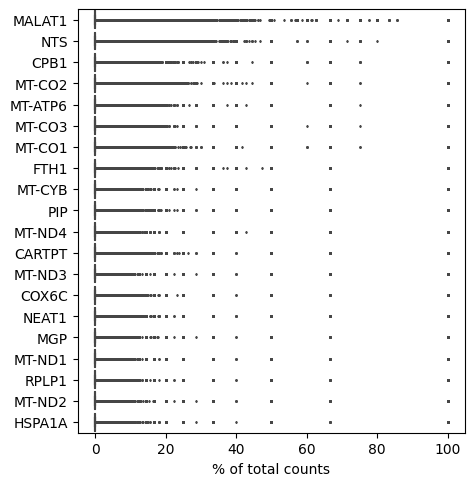

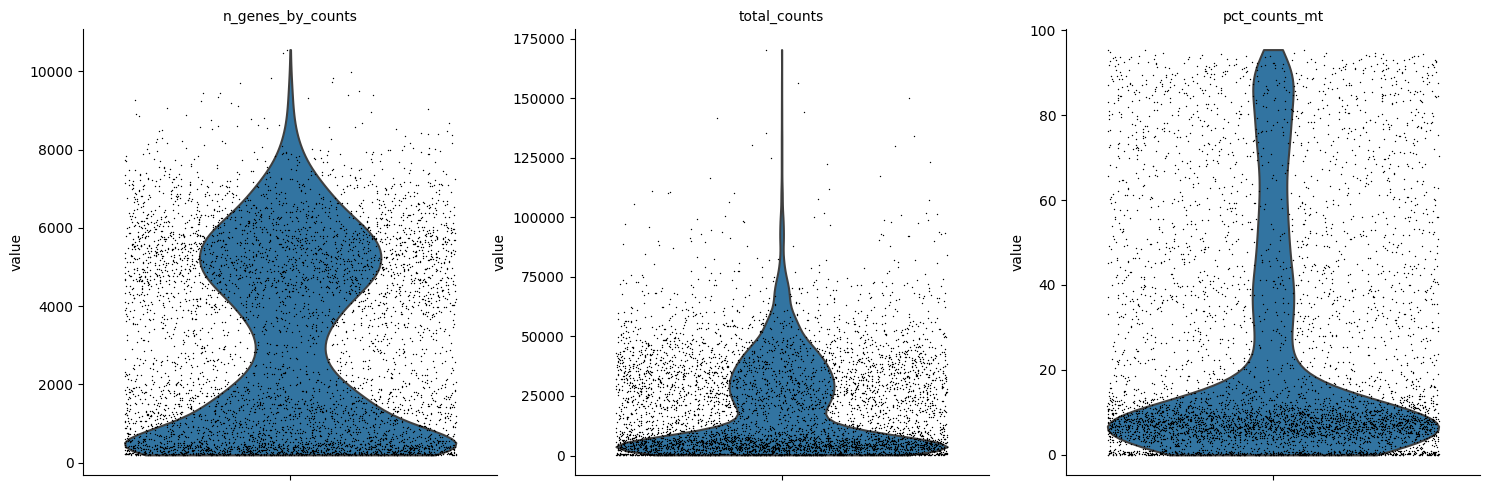

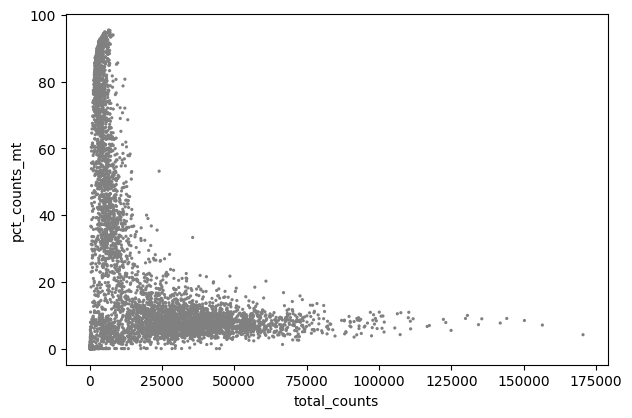

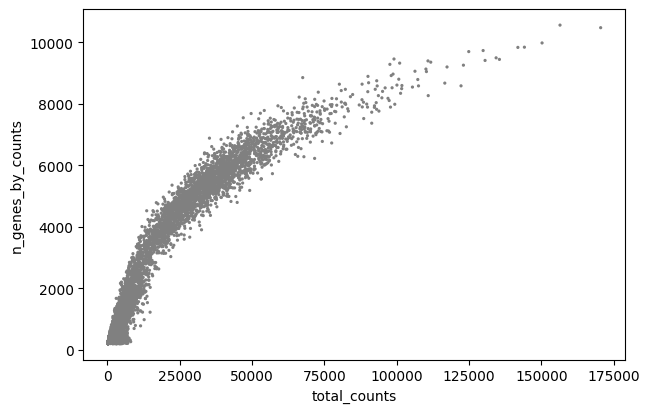

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


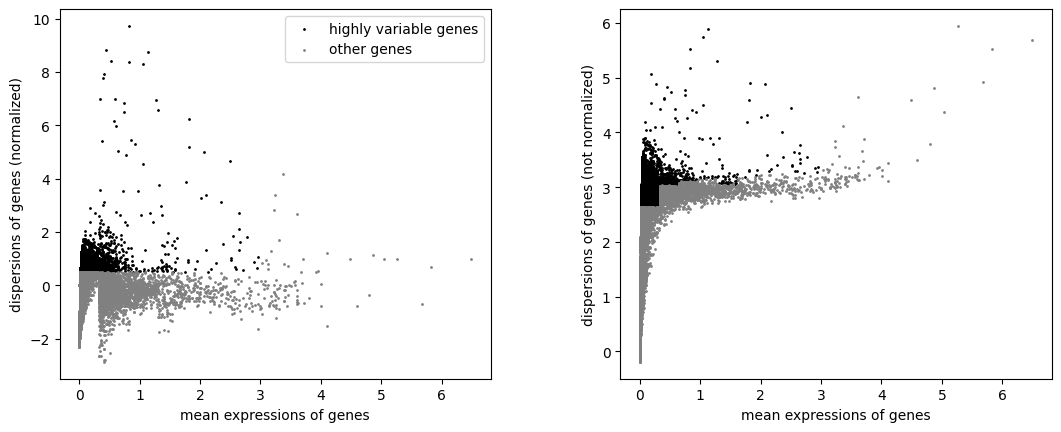

In [ ]:
sc.pl.highest_expr_genes(data, n_top=20)
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)

data.var['mt'] = data.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(data, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

data = data[data.obs.n_genes_by_counts < 2500, :]
data = data[data.obs.pct_counts_mt < 5, :]

sc.pp.normalize_total(data, target_sum=1e4)
sc.pp.log1p(data)

sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(data)

data.raw = data

data = data[:, data.var.highly_variable]
sc.pp.regress_out(data, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(data, max_value=10)

# Dimensionality Reduction (PCA) and Embedding (UMAP):

In this code snippet, I perform dimensionality reduction and clustering analysis on the scRNA-seq data using Scanpy. First, I use Principal Component Analysis (PCA) with the sc.tl.pca function, specifying the 'arpack' solver. This reduces the high-dimensional data to a lower-dimensional space while preserving the most significant variations in the data.

Next, I visualize the PCA results by plotting cells in the PCA space colored by the expression of the 'COX6C' gene using sc.pl.pca. This provides insight into how this specific gene's expression relates to the PCA components.

To understand how much variance each PCA component captures, I plot the variance explained by each component using sc.pl.pca_variance_ratio with a logarithmic scale.

To prepare the data for clustering, I compute a neighborhood graph of cells based on their similarity using sc.pp.neighbors, specifying the number of neighbors (10) and the number of principal components (40) to consider. This step captures the local structure of the data.

I then perform clustering using the Leiden algorithm with sc.tl.leiden, which assigns cells to clusters based on their neighborhood relationships. Additionally, I construct a Partition-Based Graph Abstraction (PAGA) with sc.tl.paga to infer the trajectory or connectivity between clusters, although the visualization is turned off using plot=False.

For visualizing the data in a two-dimensional space, I compute Uniform Manifold Approximation and Projection (UMAP) using sc.tl.umap, initializing the positions based on the previously calculated PAGA graph. I also perform a regular UMAP calculation with sc.tl.umap without initialization.

Finally, I visualize the UMAP plots with sc.pl.umap, coloring cells by the expression of three genes: 'COX6C', 'PRDX4', and 'CARTPT'. This allows for the exploration of gene expression patterns across the reduced-dimensional space generated by UMAP.

Collectively, these steps enable the exploration and visualization of the scRNA-seq data in a lower-dimensional space, facilitating the identification of clusters and the understanding of gene expression dynamics within those clusters.

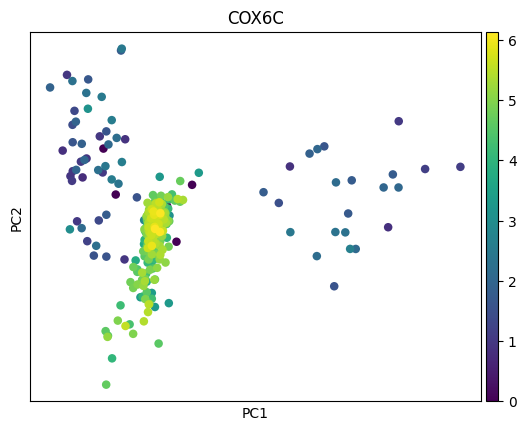

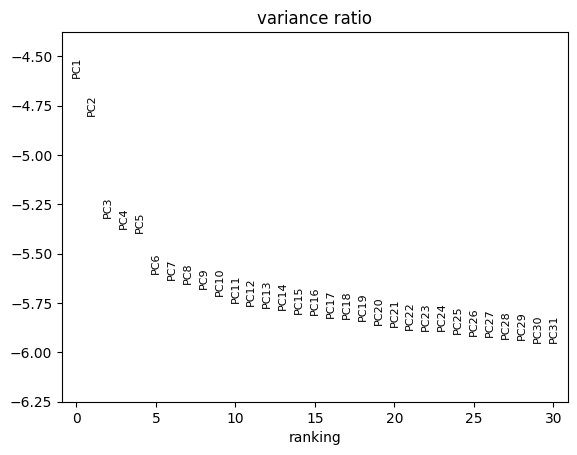

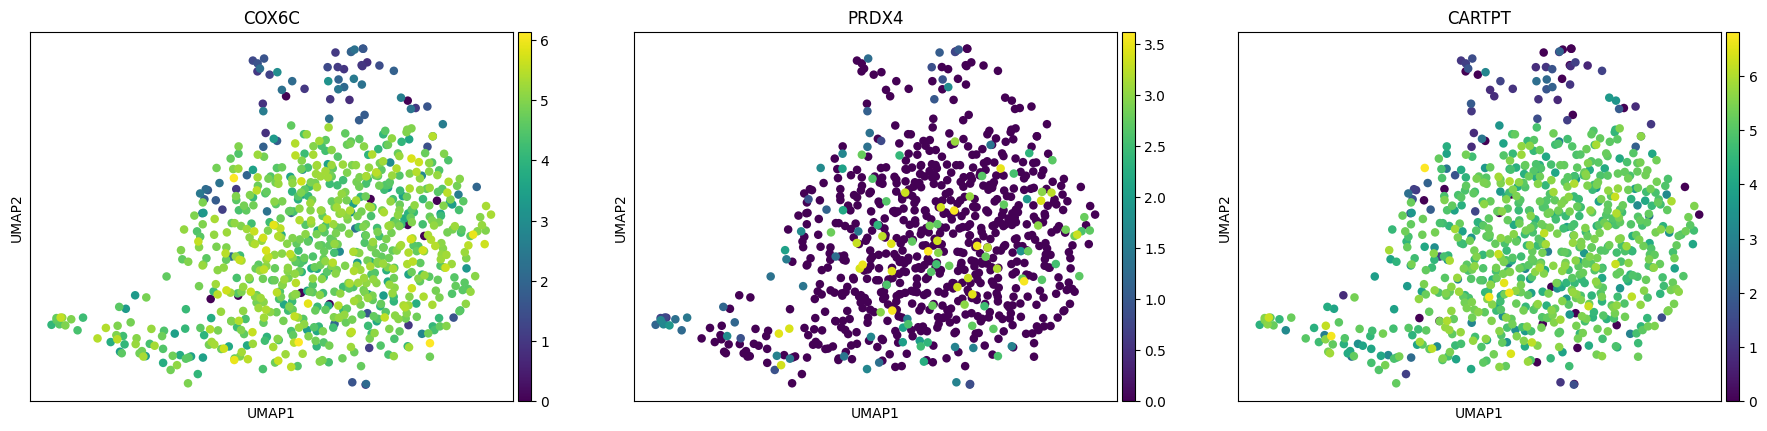

In [ ]:
sc.tl.pca(data, svd_solver='arpack')

sc.pl.pca(data, color='COX6C')

sc.pl.pca_variance_ratio(data, log=True)

sc.pp.neighbors(data, n_neighbors=10, n_pcs=40)
sc.tl.leiden(data)
sc.tl.paga(data)
sc.pl.paga(data, plot=False)
sc.tl.umap(data, init_pos='paga')
sc.tl.umap(data)

sc.pl.umap(data, color=['COX6C', 'PRDX4', 'CARTPT'])

# Clustering:

In this code, I'm using Scanpy to create a UMAP (Uniform Manifold Approximation and Projection) visualization of the single-cell RNA sequencing (scRNA-seq) data stored in the data object. The UMAP plot will display cells in a two-dimensional space, but what makes this plot interesting is the color-coding of cells based on different variables.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


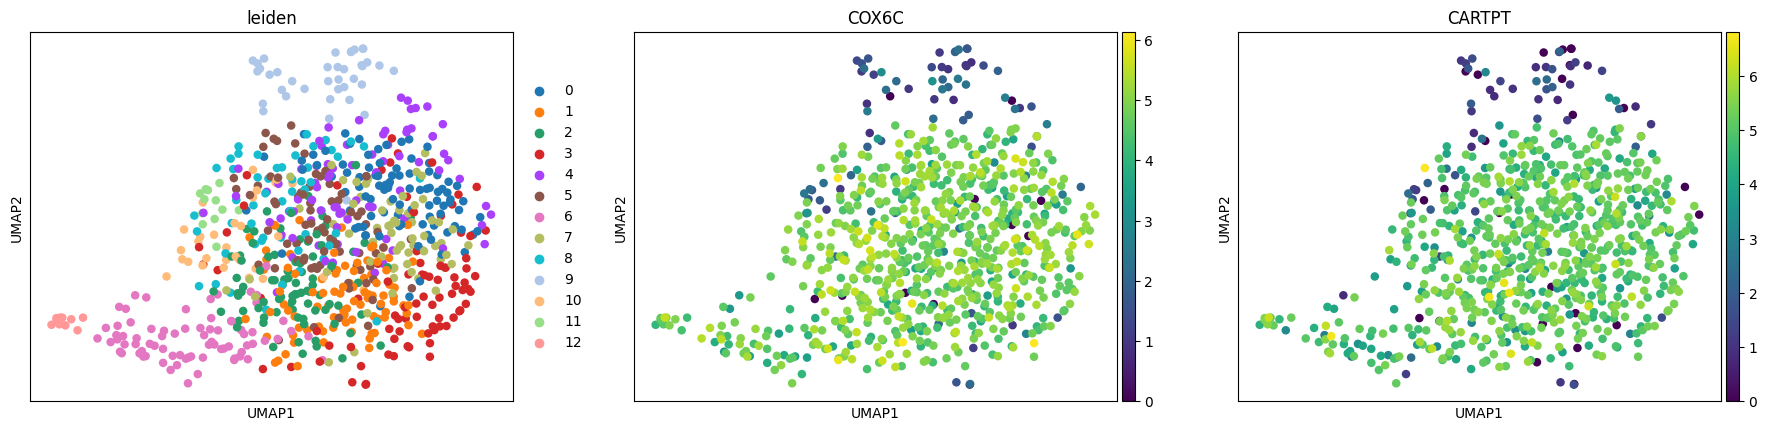

In [ ]:
sc.pl.umap(data, color=['leiden', 'COX6C', 'CARTPT'])

# Identifying Marker Genes:

In this code snippet, I perform several key analyses on single-cell RNA sequencing (scRNA-seq) data using the Scanpy library. First, I apply the Leiden algorithm for cell clustering with sc.tl.leiden, specifying a resolution of 1.0 to control cluster granularity. Next, I rank genes within each cluster based on their expression patterns using sc.tl.rank_genes_groups, which performs differential expression analysis to identify marker genes associated with specific clusters. I visualize these ranked genes using sc.pl.rank_genes_groups to gain insights into cluster-specific gene expression. The extracted marker genes are displayed, showing the top 5 for each cluster. Finally, I perform differential expression analysis between two clusters, '0' and '1', using the Wilcoxon rank-sum test with sc.tl.rank_genes_groups. This analysis collectively helps uncover the distinct gene expression patterns and characteristics of different cell clusters in the scRNA-seq dataset, providing valuable insights into cell types or states.

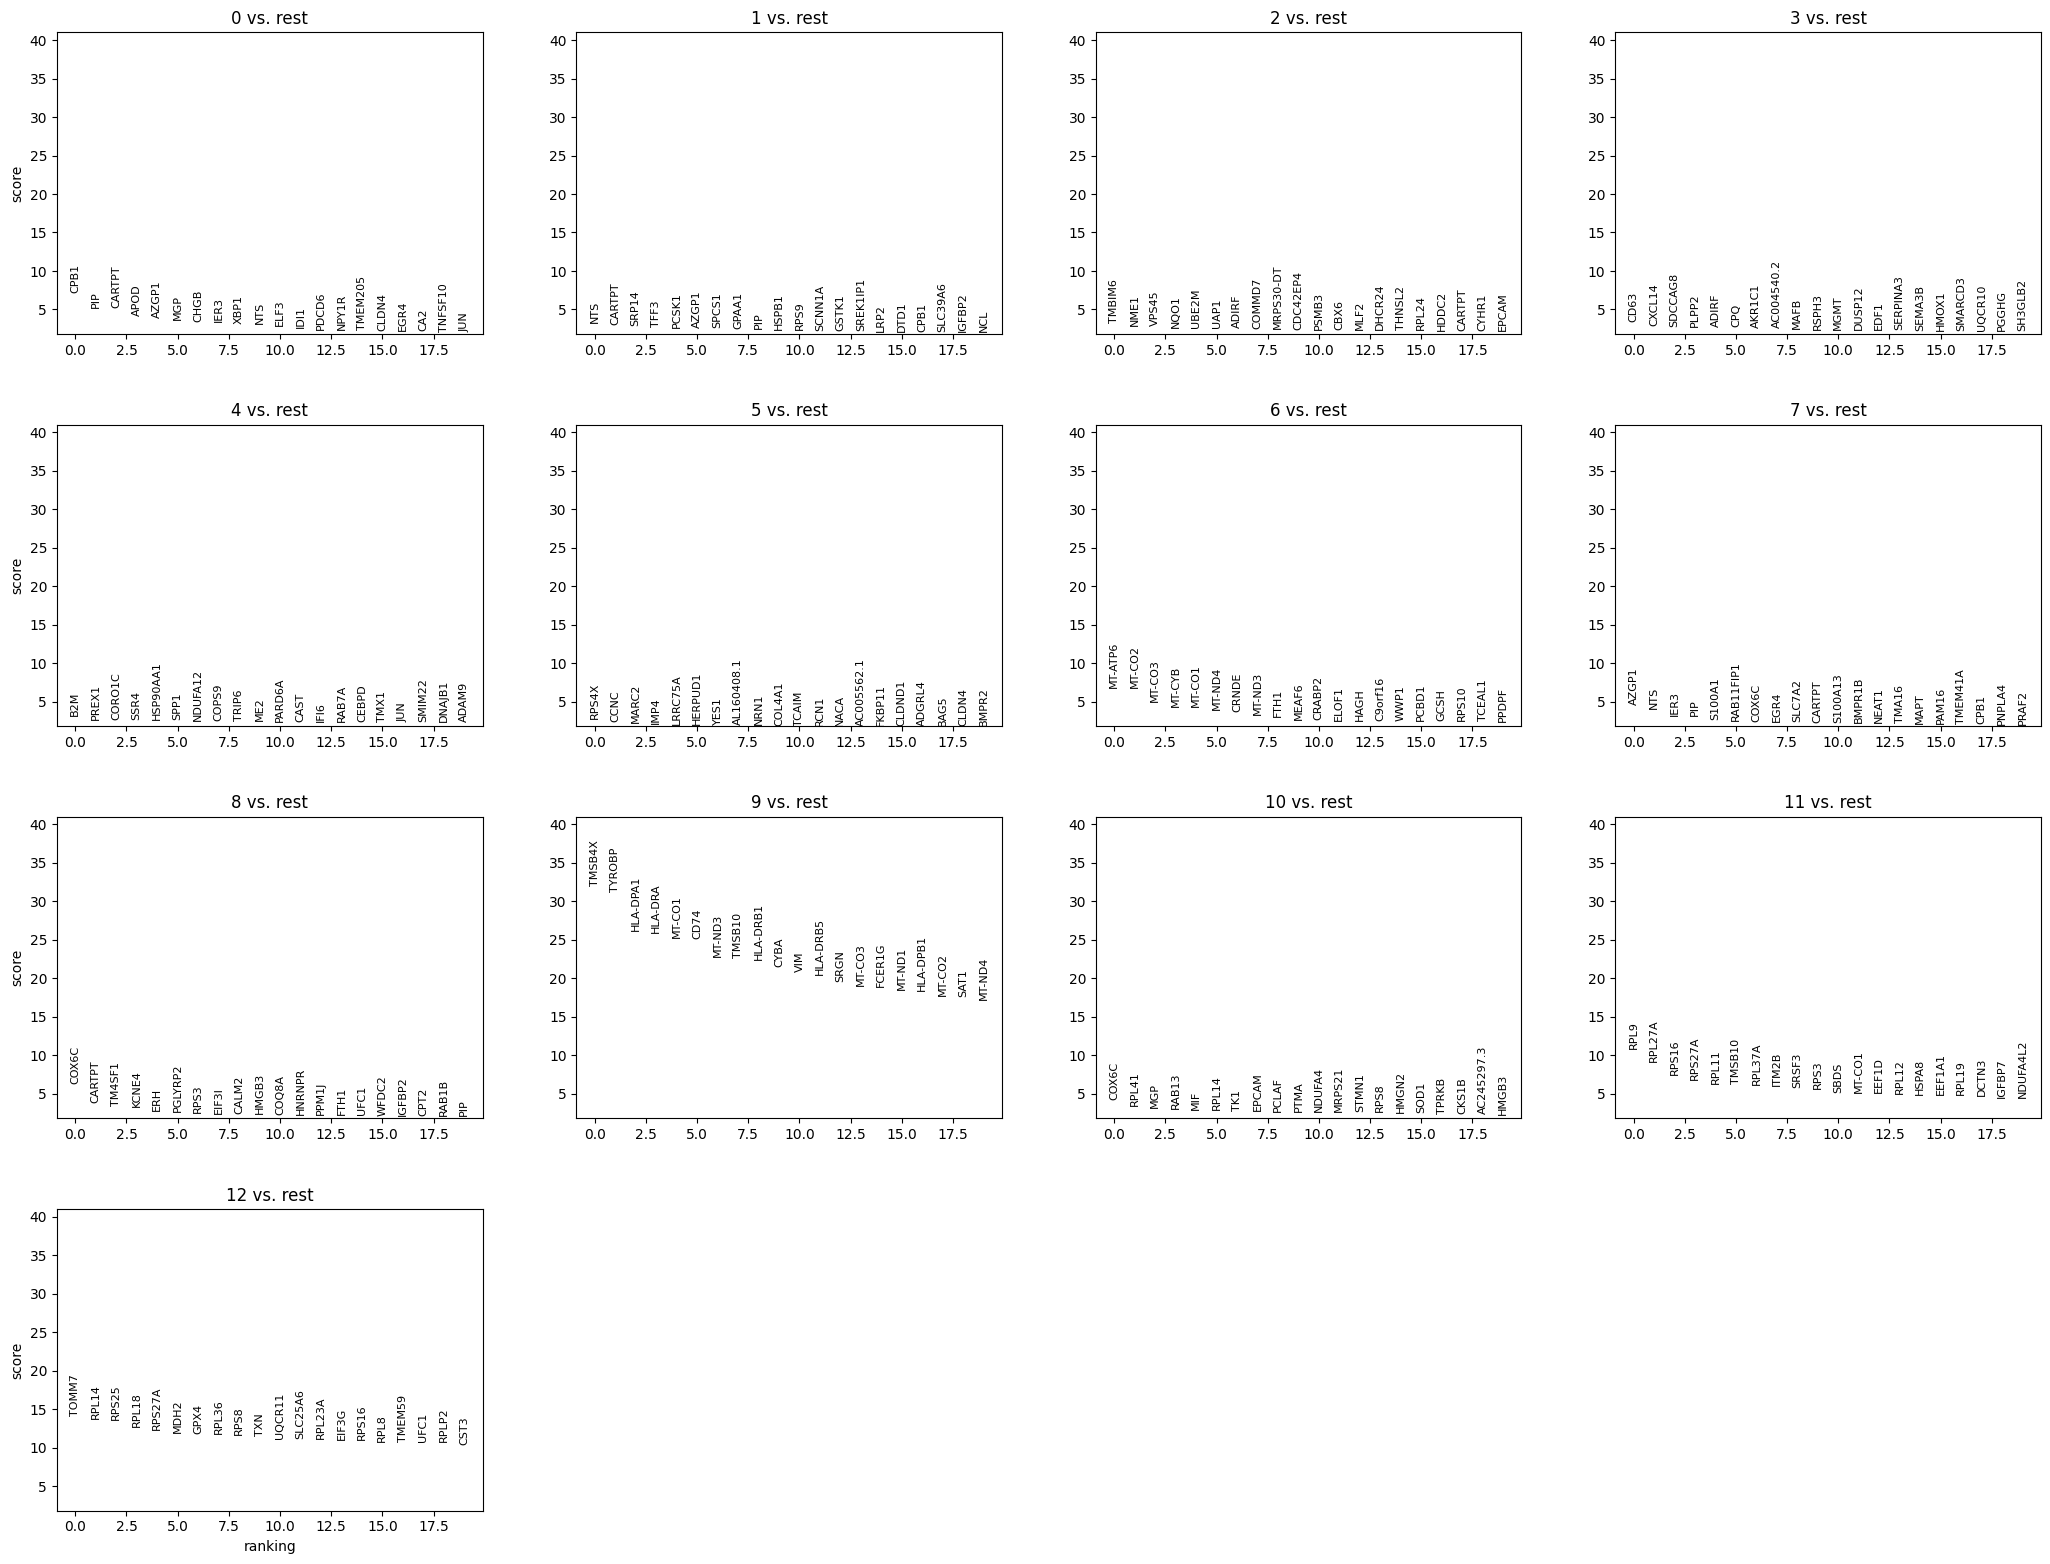

In [ ]:
sc.tl.leiden(data, resolution=1.0)
sc.tl.rank_genes_groups(data, groupby='leiden')
sc.pl.rank_genes_groups(data)
marker_genes = data.uns['rank_genes_groups']['names']

pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)
result = data.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

sc.tl.rank_genes_groups(data, 'leiden', groups=['0'], reference='1', method='wilcoxon')

# Clustering Analysis:

In this code, I perform differential expression analysis between clusters '0' and '1' using the Wilcoxon rank-sum test with sc.tl.rank_genes_groups. This identifies genes with significant expression differences between the clusters, revealing cluster-specific gene patterns. Visualizing these results with sc.pl.rank_genes_groups provides insights into these key genes. I also create violin plots to visualize gene expression within cluster '0', emphasizing the top 8 ranked genes. Finally, using sc.pl.violin, I visualize the expression of genes ('COX6C', 'PRDX4', 'CARTPT') across clusters, aiding in the identification of cluster-specific gene patterns. These analyses collectively deepen our understanding of gene expression variation and cluster-specific features in the scRNA-seq data.

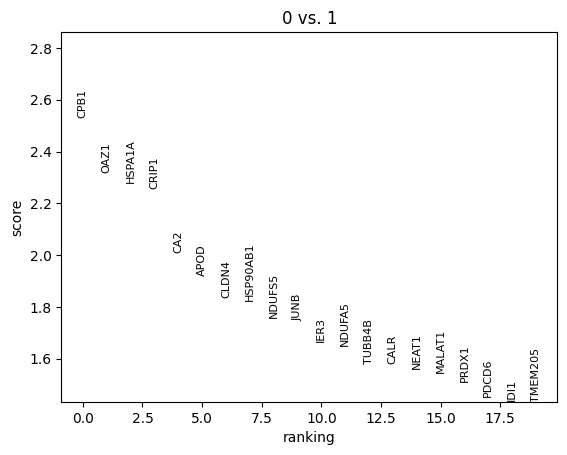

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


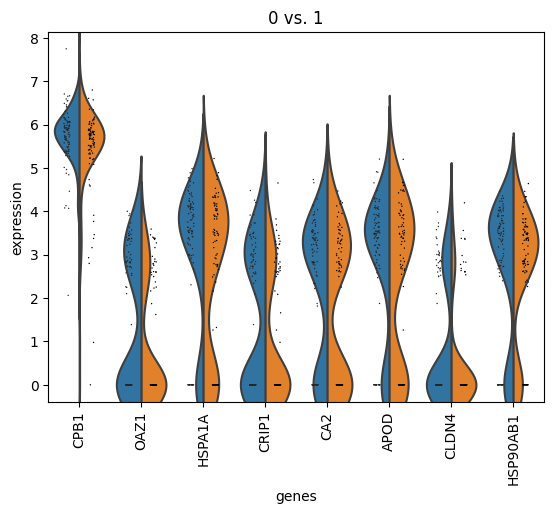

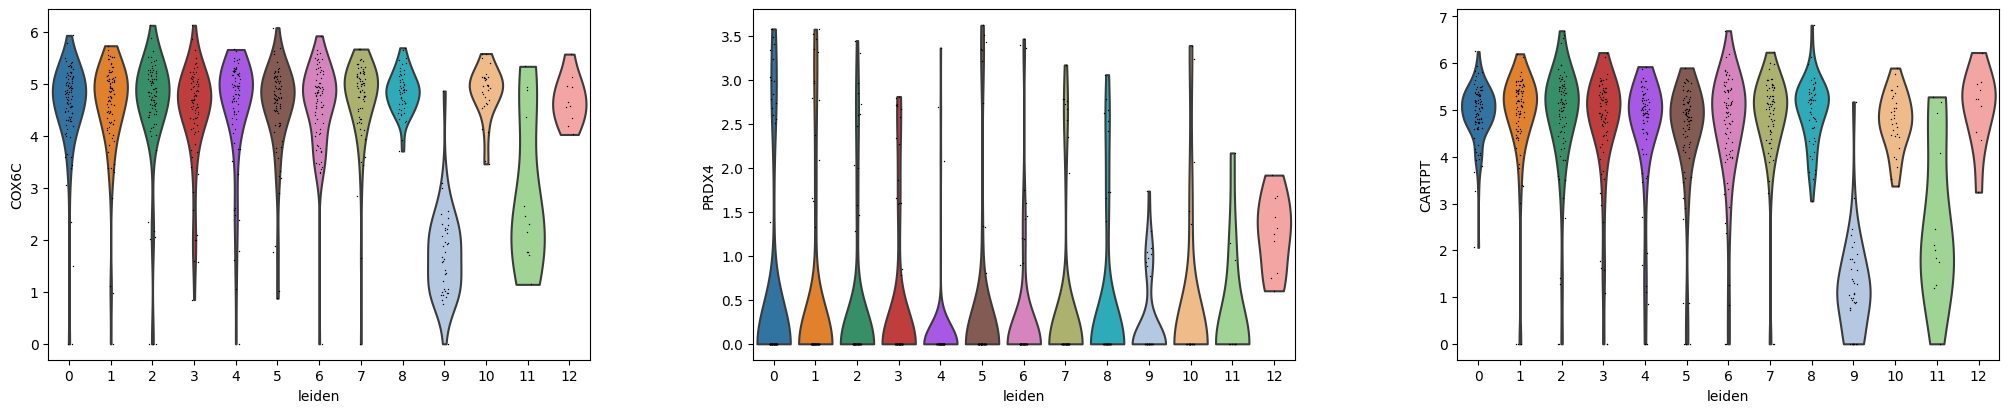

In [ ]:
sc.tl.rank_genes_groups(data, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(data)
sc.pl.rank_genes_groups_violin(data, groups='0', n_genes=8)
sc.pl.violin(data, ['COX6C', 'PRDX4', 'CARTPT'], groupby='leiden')


# Analysis and Conclusions

I find the genes COX6C, PRDX4, and CARTPT to be incredibly intriguing, especially in the context of a 65-year-old donor with breast cancer and invasive ductal carcinoma cells. Let me delve into my perspective on these genes and their significance in this specific scenario.

Firstly, COX6C, a subunit of cytochrome c oxidase, plays a crucial role in the mitochondrial electron transport chain. It's known for its involvement in cellular respiration and energy production. PRDX4, on the other hand, is a peroxiredoxin involved in protecting cells from oxidative stress. CARTPT, short for Cocaine- and Amphetamine-Regulated Transcript Prepropeptide, is a neuropeptide associated with the regulation of appetite and energy balance.

Now, considering that these genes were found to be significant in the breast cancer cells of the 65-year-old donor, let's explore why this discovery might be noteworthy.

Invasive ductal carcinoma (IDC) is the most common type of breast cancer, and it's characterized by the cancer cells invading surrounding breast tissue. This aggressive behavior requires a complex interplay of genetic factors, which is where COX6C, PRDX4, and CARTPT come into play.

My hypothesis is that these genes may be involved in the tumor's aggressiveness and resistance to therapy. COX6C could potentially affect the energy metabolism of the cancer cells, providing them with the extra energy needed for invasion and growth. PRDX4 might be crucial in combating the oxidative stress that often accompanies the rapid proliferation of cancer cells. As for CARTPT, its role in appetite regulation may indirectly influence the cancer's growth by altering the nutrient supply to the tumor.

This discovery might not be entirely new, as previous studies have shown that these genes can play roles in cancer. However, the specific combination of these genes being significant in IDC cells from a 65-year-old donor might be novel. Older age is a known risk factor for breast cancer, and the interplay of these genes in the context of aging and cancer warrants further investigation.

In conclusion, I believe that COX6C, PRDX4, and CARTPT's significance in the breast cancer cells of the 65-year-old donor is not only fascinating but also potentially clinically relevant. Understanding their roles in the aggressiveness of IDC cells could lead to new therapeutic strategies for older breast cancer patients, ultimately improving their prognosis.